In [769]:
import matplotlib.pyplot as plt
import importlib
import bitmap_editor
importlib.reload(bitmap_editor)
import numpy as np

height = 30
width = 30
bitmap_matrix = np.zeros(shape=(height,width))
bitmapEditor = bitmap_editor.BitmapEditor(bitmap_matrix)

Canvas(height=300, width=300)

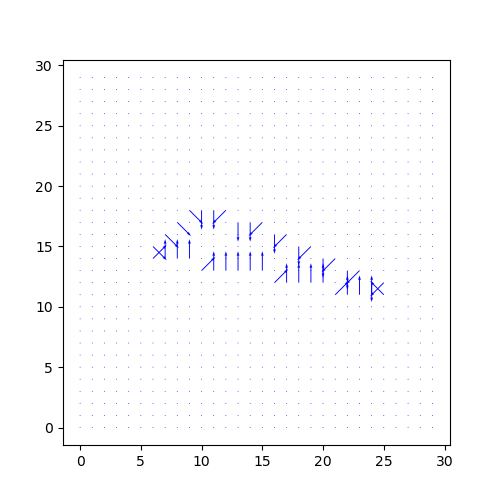

In [792]:
import navier_stokes
importlib.reload(navier_stokes)

grid = np.flip(np.copy(bitmap_matrix), 0)

w = np.full(grid.shape + (2,), [1,0])
cells = navier_stokes.cells(grid)
fluid_cells = [c for c in cells.flat if isinstance(c, navier_stokes.FluidCell)]
A = navier_stokes.projection_A(fluid_cells)
b = navier_stokes.projection_b(fluid_cells, w)

In [597]:

with np.printoptions(threshold=np.inf):
    print(A)

print(b)
print(len(b))
print(A.shape)

[[-4.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0. ]
 [ 0.   0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   

14
1.275912527742678e-08


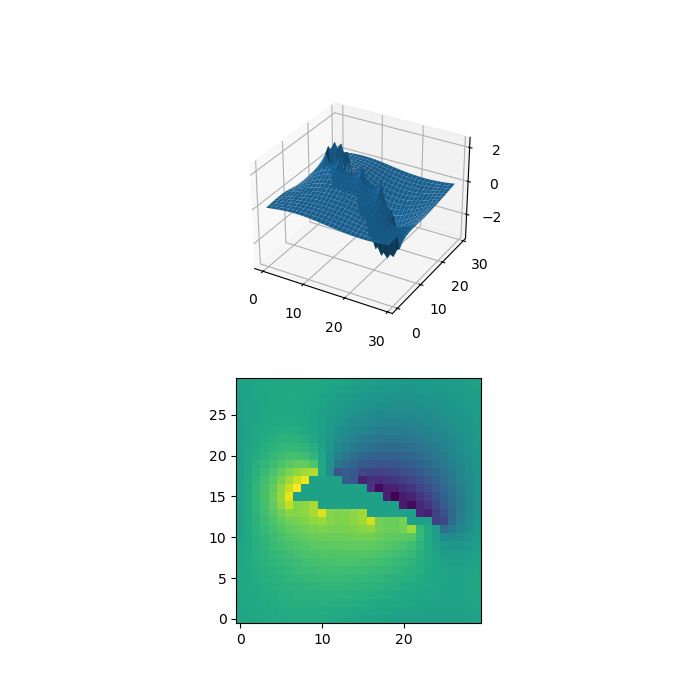

In [790]:
%matplotlib widget
import pyamg

ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
residuals = []
x = ml.solve(b, tol=1e-8, maxiter=100, residuals=residuals)
print(len(residuals))
print(residuals[-1])
# x = np.linalg.solve(A,b)


mesh = np.zeros(shape=(height,width))

avg = np.average(x)
# print(avg)

for cell in cells.flat:
    if isinstance(cell, navier_stokes.ObstacleInteriorCell):
        mesh[cell.index] = avg
        continue
    if isinstance(cell, navier_stokes.FluidCell):
        mesh[cell.index] = x[cell.num]

for cell in cells.flat:
    if isinstance(cell, navier_stokes.BoundaryCell):
        w = np.array([1, 0])
        # g = (other_x*abs(nx) + other_y*abs(ny) + b)/(np.abs(nx + ny))
        an_x = np.abs(cell.normal[0])
        an_y = np.abs(cell.normal[1])
        mesh[cell.index] = np.dot(w, cell.normal)/(an_x + an_y)
        if cell.x_diff:
            mesh[cell.index] += mesh[cell.x_diff.fluid_cell.index]*an_x/(an_x + an_y)
        if cell.y_diff:
            mesh[cell.index] += mesh[cell.y_diff.fluid_cell.index]*an_y/(an_x + an_y)


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)
ax2.imshow(mesh, interpolation='none', origin='lower')

# plt.imshow(mesh, interpolation='none', origin='lower')
ax.plot_surface(X,Y,mesh) 
plt.show()

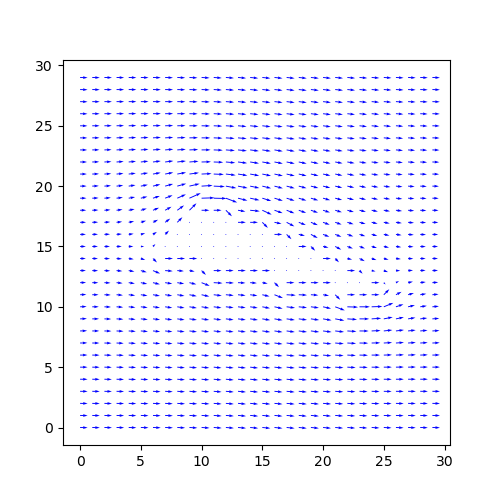

In [791]:
U = np.zeros(shape=mesh.shape)
V = np.zeros(shape=mesh.shape)

for cell in cells.flat:
    match cell:
        case navier_stokes.FluidCell(j=j,i=i):
            U[j][i] = (mesh[j][(i+1)%width] - mesh[j][(i-1)%width])/2
            V[j][i] = (mesh[(j+1)%height][i] - mesh[(j-1)%height][i])/2
        case navier_stokes.BoundaryCell(j=j,i=i,x_diff=x_diff,y_diff=y_diff):
            if x_diff:
                U[j][i] = (mesh[x_diff.fluid_cell.index] - mesh[j][i])*x_diff.dir
            if y_diff:
                V[j][i] = (mesh[y_diff.fluid_cell.index] - mesh[j][i])*y_diff.dir

newU = 1-U

for cell in cells.flat:
    if isinstance(cell, navier_stokes.ObstacleInteriorCell):
        newU[cell.index]=0

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, newU, -V, color="b")
# ax.quiver(X, Y, U,V, color="r")
plt.show()